In [1]:
import pickle
import datetime

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import hsv_to_rgb
from tensorboard import SummaryWriter
from scipy.stats import multivariate_normal

from mock_data import iter_samples, MockDataset

# Data loading
- Load csv into three separate pytorch "DataLoader"s, train, validation, and test.

In [2]:
def plot_transition(d, rotate=False):
    
    if rotate:
        d = d.copy()
        
        # translate
        dx, dy = d[['y0', 'y1']]
        d[['x0', 'y0', 'y_0']] -= dx
        d[['x1', 'y1', 'y_1']] -= dy
        
        # rotate
        θ = -d['y2']
        for prefix in ['x', 'x_', 'y_', 'u', 'y']:
            x = d[prefix + '0'].copy()
            y = d[prefix + '1'].copy()
            d[prefix + '0'] = np.cos(θ) * x - np.sin(θ) * y
            d[prefix + '1'] = np.sin(θ) * x + np.cos(θ) * y
            if prefix is not 'u':
                d[prefix + '2'] += θ

    k = 0.05
    head_width=0.02
    plt.arrow(d['x0'], d['x1'],  k * np.cos(d['x2']), k * np.sin(d['x2']), head_width=head_width, color='black')
    plt.arrow(d['x0'], d['x1'], -k * np.sin(d['x2']), k * np.cos(d['x2']), head_width=head_width, color='black')
    
    plt.arrow(d['x_0'], d['x_1'],  k * np.cos(d['x_2']), k * np.sin(d['x_2']), head_width=head_width, color='grey')
    plt.arrow(d['x_0'], d['x_1'], -k * np.sin(d['x_2']), k * np.cos(d['x_2']), head_width=head_width, color='grey')

    plt.arrow(d['y0'], d['y1'],  k * np.cos(d['y2']), k * np.sin(d['y2']), head_width=head_width, color='red')
    plt.arrow(d['y0'], d['y1'], -k * np.sin(d['y2']), k * np.cos(d['y2']), head_width=head_width, color='red')

    plt.arrow(d['y_0'], d['y_1'],  k * np.cos(d['y_2']), k * np.sin(d['y_2']), head_width=head_width, color='pink')
    plt.arrow(d['y_0'], d['y_1'], -k * np.sin(d['y_2']), k * np.cos(d['y_2']), head_width=head_width, color='pink')

    t = d['u3']
    plt.arrow(d['x0'], d['x1'],  t * d['u0'], t * d['u1'], head_width=0.03, color='blue')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.grid()

In [3]:
n_samples = 100000
dataset_np = np.zeros((n_samples, 23))
for i, row in enumerate(iter_samples()):
    dataset_np[i, :] = row
    if i >= n_samples - 1:
        break
dataset = pd.DataFrame(data=dataset_np,
                       columns=['x0','x1','x2','y0',
                                'y1','y2','x_0','x_1',
                                'x_2','y_0','y_1','y_2',
                                'u0','u1','u2','u3',
                                'u4','w','h','m',
                                'I','µ','type'])

In [4]:
#types = {
#    'x0': np.float32,
#    'x1': np.float32,
#    'x2': np.float32,
#    'y0': np.float32,
#    'y1': np.float32,
#    'y2': np.float32,
#    'x_0': np.float32,
#    'x_1': np.float32,
#    'x_2': np.float32,
#    'y_0': np.float32,
#    'y_1': np.float32,
#    'y_2': np.float32,
#    'u0': np.float32,
#    'u1': np.float32,
#    'u2': np.float32,
#    'u3': np.float32,
#    'u4': np.float32,
#    'w': np.float32,
#    'h': np.float32,
#    'm': np.float32,
#    'I': np.float32,
#    'µ': np.float32,
#    'type': str
#}
#dataset = pd.read_csv('./data/data/concatenated.csv', dtype=types, sep='\s*,\s*', engine='python', nrows=100)

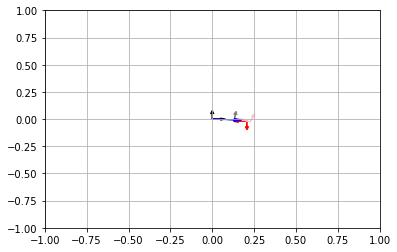

In [5]:
i = np.random.randint(0, n_samples)
plot_transition(dataset.iloc[i])
plt.show()

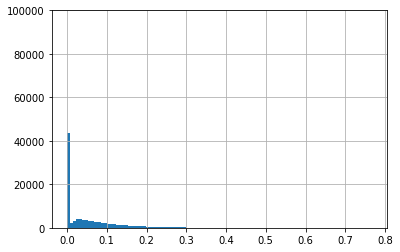

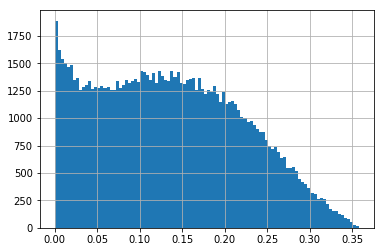

0.3583211508495439

In [6]:
(((dataset[['y0', 'y1']] - dataset[['y_0', 'y_1']].values) ** 2).sum(axis=1) ** 0.5).hist(bins=100)
plt.ylim(0, 100000)
plt.show()
(((dataset[['x0', 'x1']] - dataset[['x_0', 'x_1']].values) ** 2).sum(axis=1) ** 0.5).hist(bins=100)
plt.show()
(((dataset[['x0', 'x1']] - dataset[['x_0', 'x_1']].values) ** 2).sum(axis=1) ** 0.5).max()

In [7]:
dataset.var()

x0      0.000000
x1      0.000000
x2      0.000000
y0      0.022564
y1      0.022508
y2      3.273479
x_0     0.012792
x_1     0.012722
x_2     0.030128
y_0     0.036125
y_1     0.035870
y_2     4.242417
u0      0.060335
u1      0.059916
u2      0.119681
u3      0.023100
u4      1.011136
w       0.000678
h       0.000678
m       0.012636
I       0.999598
µ       0.012672
type    0.000000
dtype: float64

In [8]:
mask = (
    (dataset['y_0'] == dataset['y0']) &
    (dataset['y_1'] == dataset['y1'])
)
non_moving = dataset[mask][['y0', 'y1', 'y2', 'y_0', 'y_1', 'y_2']]
sub_dataset = dataset.drop(non_moving.sample(frac=0.9).index)

In [9]:
#sub_dataset[['m', 'µ', 'w', 'h']].hist(bins=100)
sub_dataset = dataset
plt.show()
x = sub_dataset[['m', 'µ', 'w', 'h']]
µ = sub_dataset[['m', 'µ', 'w', 'h']].mean()
Σ = sub_dataset[['m', 'µ', 'w', 'h']].var() / (8.0 ** 2)
sampling_probs = multivariate_normal.pdf(x, mean=µ, cov=Σ) * 0.0 + 1.0
µ, np.sqrt(Σ)

(m    0.204786
 µ    0.205028
 w    0.055020
 h    0.055020
 dtype: float64, m    0.014051
 µ    0.014071
 w    0.003255
 h    0.003255
 dtype: float64)

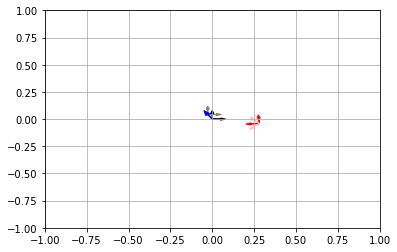

In [10]:
i = np.random.randint(0, len(sub_dataset))
plot_transition(sub_dataset.iloc[i])
plt.show()

In [11]:
dataset.head()

,x0,x1,x2,y0,y1,y2,x_0,x_1,x_2,y_0,...,u1,u2,u3,u4,w,h,m,I,µ,type
0,0.0,0.0,0.0,-0.235016,-0.030550,2.998305,-0.282555,-0.027733,0.104412,-0.357046,...,-0.057822,0.217691,0.479632,-0.193473,0.056560,0.056560,0.358058,0.659529,0.215170,666.0
1,0.0,0.0,0.0,0.163028,0.224894,-1.080828,0.173188,0.274233,0.115685,0.213527,...,0.461579,0.194717,0.594120,0.698708,0.023474,0.023474,0.374748,0.757201,0.098134,666.0
2,0.0,0.0,0.0,0.004495,0.172053,-1.944028,-0.000006,0.035818,-0.210853,0.004495,...,0.059697,-0.351421,0.600000,-0.164976,0.062687,0.062687,0.325217,-2.591346,0.363407,666.0
3,0.0,0.0,0.0,-0.204170,0.180229,-0.156792,-0.083298,0.079416,0.350472,-0.204170,...,0.132360,0.584119,0.600000,-0.917560,0.055832,0.055832,0.042032,1.152715,0.336578,666.0
4,0.0,0.0,0.0,0.083283,0.204668,-2.022958,0.147492,-0.120702,0.036014,0.083283,...,-0.275415,0.082175,0.438256,0.812979,0.052127,0.052127,0.359442,-0.682797,0.199847,666.0


In [12]:
dataset_train = sub_dataset.iloc[:int(0.8 * sub_dataset.shape[0])]
sampling_probs_train = sampling_probs[:int(0.8 * sub_dataset.shape[0])]
dataset_val = sub_dataset.iloc[int(0.8 * sub_dataset.shape[0]):int(0.9 * sub_dataset.shape[0])]
sampling_probs_val = sampling_probs[int(0.8 * sub_dataset.shape[0]):int(0.9 * sub_dataset.shape[0])]
dataset_test = sub_dataset.iloc[int(0.9 * sub_dataset.shape[0]):]
sampling_probs_test = sampling_probs[int(0.9 * sub_dataset.shape[0]):]

In [13]:
class PushingDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataframe):
        self.df = dataframe
    
    def __getitem__(self, i):
        row = self.df.iloc[i]
        
        x = row[['y0', 'y1', 'y2', 'w', 'h', 'm', 'µ']].values
        u = row[['u0', 'u1', 'u2', 'u3']].values
        y_ = row[['y_0', 'y_1', 'y_2']].values
        y = y_ - x[:3]
        y[-1] = np.arctan2(np.sin(y[-1]), np.cos(y[-1]))

        #plt.figure(figsize=(6, 6))
        #plot_transition(row)
        #plt.show()

        return (
            x.astype(np.float32),
            u.astype(np.float32),
            y.astype(np.float32),
        )
                
    def __len__(self):
        return self.df.shape[0]
    
from torch.utils.data.sampler import WeightedRandomSampler
train_size = 512
train_sampler = WeightedRandomSampler(sampling_probs_train, len(dataset_train))
val_sampler = WeightedRandomSampler(sampling_probs_val, len(dataset_val))
test_sampler = WeightedRandomSampler(sampling_probs_test, len(dataset_test))
    
#pushing_dataset_train = PushingDataset(dataset_train)
#pushing_dataset_val = PushingDataset(dataset_val)
#pushing_dataset_test = PushingDataset(dataset_test)
pushing_dataset_train = MockDataset()
pushing_dataset_val = MockDataset()
pushing_dataset_test = MockDataset()
dataloader_train = DataLoader(pushing_dataset_train, batch_size=train_size, shuffle=True, drop_last=True, num_workers=8)
dataloader_val = DataLoader(pushing_dataset_val, batch_size=1024, shuffle=True, drop_last=True)
dataloader_test = DataLoader(pushing_dataset_test, batch_size=1, shuffle=True, drop_last=True)

In [27]:
next(iter(dataloader_train))

[
 -0.0538  0.2294 -0.3159  ...   0.0974  0.0729  0.2254
 -0.0776 -0.1046  1.2976  ...   0.0861  0.2547  0.2082
 -0.2503 -0.1146 -2.9807  ...   0.0147  0.0653  0.2633
           ...             ⋱             ...          
 -0.1386  0.0171  0.9477  ...   0.0298  0.3437  0.2735
 -0.0241  0.1740  2.8616  ...   0.0933  0.1143  0.3558
 -0.2675  0.0221  1.4427  ...   0.0524  0.1748  0.0806
 [torch.FloatTensor of size 512x7], 
  0.0951 -0.3032 -0.0940  0.0537
 -0.0073 -0.0109 -0.5683  0.6000
 -0.1100 -0.0501 -0.1739  0.6000
                ⋮                
 -0.3116  0.0204 -0.2804  0.5149
 -0.0129  0.0691  0.4073  0.6000
 -0.2914  0.0021 -0.4115  0.6000
 [torch.FloatTensor of size 512x4], 
  0.0000  0.0000  1.7568
  0.0000  0.0000 -0.0702
  0.0000  0.0000 -0.8345
            ⋮            
 -0.0549  0.0075 -1.2786
  0.0000  0.0000 -0.4939
 -0.0093  0.0022 -1.4121
 [torch.FloatTensor of size 512x3]]

# Define models
- Separate mean and variance models, for stability
- MSE loss for the mean, gaussian log likelihood for the variance
- Learn: $p(u|x_r, x_t, x_t')$

In [28]:
class Normalization(torch.nn.Module):
    
    def __init__(self, n_features):
        super(Normalization, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        y = (x - Variable(self.mean)) / (Variable(self.std) + 1e-9)
        return y.clamp(-5, 5)
    
class NormalizationInverse(torch.nn.Module):
    
    def __init__(self, n_features):
        super(NormalizationInverse, self).__init__()
        self.register_buffer('mean', torch.zeros(n_features))
        self.register_buffer('std', torch.ones(n_features))
        
    def forward(self, x):
        return x * Variable(self.std) + Variable(self.mean)

In [29]:
def normalizers(sub_dataset):
    mean = sub_dataset.mean().values
    std = sub_dataset.std().values
    norm = Normalization(mean.shape[0])
    norm_inv = NormalizationInverse(mean.shape[0])
    norm.mean = norm_inv.mean = torch.FloatTensor(mean)
    norm.std = norm_inv.std = torch.FloatTensor(std)
    return norm.cuda(), norm_inv.cuda()

x_dataset = dataset_train[['y0', 'y1', 'y2', 'w', 'h', 'm', 'µ']]
u_dataset = dataset_train[['u0', 'u1', 'u2', 'u3']]
y_dataset = dataset_train[['y_0', 'y_1', 'y_2']] - dataset_train[['y0', 'y1', 'y2']].values
norm_x, norminv_x = normalizers(x_dataset)
norm_u, norminv_u = normalizers(u_dataset)
norm_y, norminv_y = normalizers(y_dataset)
norm_y.mean *= 0.0
norminv_y.mean *= 0.0

In [30]:
class Residual(torch.nn.Module):
    
    def __init__(self, num_features):
        super(Residual, self).__init__()
        self.bn1 = torch.nn.BatchNorm1d(num_features)
        self.fc1 = torch.nn.Linear(num_features, num_features)
        self.bn2 = torch.nn.BatchNorm1d(num_features)
        self.fc2 = torch.nn.Linear(num_features, num_features)
        
    def forward(self, x):
        a = self.fc1(F.relu(self.bn1(x)))
        b = self.fc2(F.relu(self.bn2(a)))
        return b + x

In [32]:
class RewardFCPlain(torch.nn.Module):
    
    def __init__(self, x_size, u_size, y_size, hidden_units=256):
        super(RewardFCPlain, self).__init__()
        
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(x_size + u_size, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, y_size)  # E[Y]
        )
        
    def forward(self, x, u):
        xu = torch.cat([x, u], dim=1)
        y = self.sequential(xu)                    # E(Y)
        # Var(Y) = E(Y^2) - E(Y)^2
        # E(Y^2) = Var(Y) + E(Y)^2
        # y2 = F.softplus(self.fcy2(a2)) + y ** 2 # E(Y^2)
        # t = F.softplus(self.fct(a2))
        return y

class FCPositive(torch.nn.Module):
    
    def __init__(self, x_size, u_size, y_size, hidden_units=256):
        super(FCPositive, self).__init__()
        
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(x_size + u_size, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.BatchNorm1d(hidden_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_units, y_size),
            torch.nn.Softplus()
        )
        
    def forward(self, x, u):
        xu = torch.cat([x, u], dim=1)
        y = self.sequential(xu)
        return y
    
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
reward = RewardFCPlain(X.size(1), U.size(1), Y.size(1)).cuda()
#variance = FCPositive(X.size(1), U.size(1), Y.size(1)).cuda()
optim_mean = torch.optim.Adam(reward.parameters(), weight_decay=1e-3, betas=(0.99, 0.999))
#optim_variance = torch.optim.Adam(variance.parameters(), weight_decay=1e-3, betas=(0.99, 0.999))

In [33]:
reward.eval()
X, U, Y = next(iter(dataloader_val))
reward(Variable(X.cuda()), Variable(U.cuda()))

Variable containing:
1.00000e-02 *
 2.8006  5.0344 -3.2337
 2.6378  4.8656 -2.9829
 2.7587  4.8456 -3.0743
           ⋮            
 2.7458  4.8886 -3.0395
 2.7280  4.8343 -2.9556
 2.6409  4.7602 -2.9661
[torch.cuda.FloatTensor of size 1024x3 (GPU 0)]

In [34]:
dataset_train.__len__()

80000

In [35]:
time_str = datetime.datetime.now().strftime('%H:%M')
logger_train = SummaryWriter('runs/mock-{}-nll-train-256'.format(time_str))
logger_valid = SummaryWriter('runs/mock-{}-nll-valid-256'.format(time_str))
optim_mean = torch.optim.Adam(reward.parameters(), weight_decay=1e-4, betas=(0.99, 0.999))
loss_fn = torch.nn.MSELoss()
best_val = np.inf
best_models = None
step = -1
n_steps = 500000

while True:
    for X, U, Y in dataloader_train:
        reward.train()
        step += 1
        X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
        X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
        Y_pred = reward(X, U)
        reward.zero_grad()
        loss_mean = loss_fn(Y_pred, Y)
        loss_mean.backward()
        optim_mean.step()

        if step % 50 == 0:
            logger_train.add_scalar('mean', loss_mean.cpu().data[0], step)
            
            # validation
            reward.eval()
            X, U, Y = next(iter(dataloader_val))
            X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
            X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
            Y_pred = reward(X, U)
            loss_mean = loss_fn(Y_pred, Y)
            logger_valid.add_scalar('mean', loss_mean.cpu().data[0], step)
            val_loss = loss_mean.cpu().data[0]
            if val_loss < best_val:
                best_val = val_loss
                best_models = reward.state_dict(),
        if step > n_steps:
            break
    if step > n_steps:
        break

Process Process-45:
Process Process-48:
Process Process-43:
Process Process-42:
Process Process-44:
Process Process-47:
Process Process-46:
Process Process-41:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/isacar/works

  File "/home/isacar/workspace/oracle/mock_data.py", line 21, in propagate
    move_vectors = np.hstack([np.cos(obj_angles), np.sin(obj_angles)]) * move_distances
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/numpy/core/shape_base.py", line 288, in hstack
    return _nx.concatenate(arrs, 1)
KeyboardInterrupt


KeyboardInterrupt: 

In [36]:
reward.eval()
reward.load_state_dict(best_models[0])

X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
variance = FCPositive(X.size(1), U.size(1), Y.size(1)).cuda()
optim_variance = torch.optim.Adam(variance.parameters(), weight_decay=1e-4)
best_val = np.inf
best_variance_model = None
step = -1
n_steps = 500000

def loss_fn(Y, mean_pred, var_pred):
    N = Y.size(0)
    y_err = Y - mean_pred
    nll = (torch.log(var_pred).sum() + (y_err ** 2 / var_pred).sum()) / N
    return nll

while True:
    for X, U, Y in dataloader_train:
        variance.train()
        step += 1
        X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
        X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
        Y_pred = reward(X, U)
        Y2_pred = variance(X, U)
        variance.zero_grad()
        loss_variance = loss_fn(Y, Y_pred.detach(), Y2_pred)
        loss_variance.backward()
        optim_variance.step()

        if step % 50 == 0:
            logger_train.add_scalar('loss_variance', loss_variance.cpu().data[0], step)
            
            # validation
            variance.eval()
            X, U, Y = next(iter(dataloader_val))
            X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
            X, U, Y = norm_x(X), norm_u(U), norm_y(Y)
            Y_pred = reward(X, U)
            Y2_pred = variance(X, U)
            loss_variance = loss_fn(Y, Y_pred.detach(), Y2_pred)
            logger_valid.add_scalar('loss_variance', loss_variance.cpu().data[0], step)
            val_loss = loss_variance.cpu().data[0]
            if val_loss < best_val:
                best_val = val_loss
                best_variance_model = variance.state_dict()
        if step > n_steps:
            break
    if step > n_steps:
        break

Process Process-52:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-51:
Process Process-50:
Process Process-53:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
Process Process-55:
Process Process-49:
Traceback (most recent call last):
  File "/home/isacar/workspace/oracle/mock_data.py", line 82, in __getitem__
    row = 

KeyboardInterrupt: 

  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Process Process-56:
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/isacar/workspace/oracle/mock_data.py", line 82, in __getitem__
    row = next(self.iterator)
  File "/home/isacar/workspace/oracle/mock_data.py", line 59, in iter_samples
    y = propagate(x, u)
  File "/home/isacar/workspace/oracle/mock_data.py", line 23, in propagate
    return np.hstack([move_vectors_noisy, np.random.uniform(-1.0, 1.0, size=(obj.shape[0], 1))])
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run

In [37]:
reward.eval()
variance.eval()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
reward(norm_x(X), norm_u(U))[:1, :], norm_y(Y[:1, :])

(Variable containing:
 1.00000e-02 *
   1.2520 -0.2095 -0.8650
 [torch.cuda.FloatTensor of size 1x3 (GPU 0)], Variable containing:
  0.0000  0.0000  1.1562
 [torch.cuda.FloatTensor of size 1x3 (GPU 0)])

In [38]:
variance.eval()
variance.load_state_dict(best_variance_model)
#with open('notebook_models/reward.pkl', 'wb') as f:
#    pickle.dump(reward.state_dict(), f)
#with open('notebook_models/variance.pkl', 'wb') as f:
#    pickle.dump(variance.state_dict(), f)
#X, U, Y = next(iter(dataloader_val))
#X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
#X, U, Y = norm_x(X)[:1, :], norm_u(U)[:1, :], norm_y(Y)[:1, :]

In [13]:
with open('notebook_models/reward.pkl', 'rb') as f:
    reward.load_state_dict(pickle.load(f))
with open('notebook_models/variance.pkl', 'rb') as f:
    variance.load_state_dict(pickle.load(f))

In [87]:
class ExpectedDistance(torch.nn.Module):
    
    def __init__(self, mean_model, variance_model):
        super(ExpectedDistance, self).__init__()
        self.mean = mean_model
        self.variance = variance_model
        self.register_buffer(
            'weights',
            torch.FloatTensor([1.0, 1.0, 0.1])
        )
        
    def forward(self, x, u, g):
        """
        Variables should all be normalized!
        Goal is relative object! G_rel = (G - X)
        Goal is normalized with same as Y = (X' - X)
        """
        mean = self.mean(x, u)
        var = self.variance(x, u)
        return ((var + (mean - g) ** 2) * Variable(self.weights)).mean(dim=1)
    
expect_distance = ExpectedDistance(reward, variance).cuda()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
norm_x = norm_x.cuda()
norm_u = norm_u.cuda()
norm_y = norm_y.cuda()
expect_distance(norm_x(X), norm_u(U), norm_y(Y))

Variable containing:
 0.0650
 0.7570
 0.0381
   ⋮   
 0.0374
 0.0475
 0.0529
[torch.cuda.FloatTensor of size 1024 (GPU 0)]

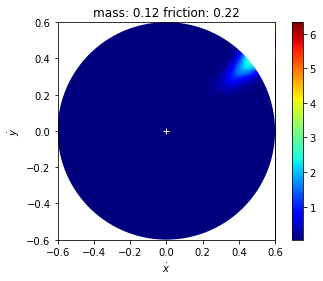

In [94]:
def plot_q(π=None, X=None, G=None, duration=0.6, mass=0.10, friction=0.05):
    reward.eval()
    variance.eval()
    obj_x = 0.0; obj_y = -0.3
    width = 0.10
    if X is None:
        X = Variable(torch.cuda.FloatTensor([[obj_x, obj_y, 0.0, width, width, mass, friction]]))
    else:
        X = X[:1, :]
        mass = X[0, -2].cpu().data[0]
        friction = X[0, -1].data[0]
    _, U, Y = next(iter(dataloader_val))
    U = Variable(U.cuda())[:1, :]
    g = 0.2 * np.array([obj_x, obj_y, 0.0]) / np.sqrt(obj_x ** 2 + obj_y ** 2)
    if G is None:
        G = Variable(torch.cuda.FloatTensor(g)).resize(1, 3)
    else:
        G = G[:1, :]
    if π:
        U = π(norm_x(X), norm_y(G)).cpu().data.numpy().flatten()
        duration = float(U[-1])
    U = Variable(torch.cuda.FloatTensor([[0.0, 0.0, 0.0, duration]]))
    
    res = 32
    u_range = 0.6
    img = np.zeros((res, res))
    img_var = np.zeros((res, res))
    min_dist = np.inf
    min_x_y = None
    for i, ux in enumerate(np.linspace(-u_range, u_range, res)):
        for j, uy in enumerate(np.linspace(-u_range, u_range, res)):
            U[0, 0] = ux
            U[0, 1] = uy
            d = expect_distance(norm_x(X), norm_u(U), norm_y(G)).cpu().data[0]
            img[j, i] = d
            if d < min_dist:
                min_dist = d
                min_x_y = (ux, uy)
            
    fig, ax = plt.subplots(figsize=(6, 4))
    if π:
        U = π(norm_x(X), norm_y(G)).cpu().data.numpy().flatten()
        plt.plot(U[0], U[1], 'ko', markersize=5.0)
        plt.plot(U[0], U[1], 'wo', markersize=4.0)
    #plt.plot(*min_x_y, 'ko', markersize=5.0)
    #plt.plot(*min_x_y, 'wo', markersize=4.0)
    circle = plt.Circle((0, 0), radius=u_range + 0.69, fill=False, linewidth=250, color='white')
    mappable = ax.imshow(img, extent=[-u_range, u_range, -u_range, u_range], origin='lower', interpolation='gaussian', cmap='jet')
    ax.add_artist(circle)
    ax.plot(0, 0, 'w+')
    ax.set_title('mass: {:.2f} friction: {:.2f}'.format(mass, friction))
    ax.set_xlabel('$\dot{x}$')
    ax.set_ylabel('$\dot{y}$')
    plt.colorbar(mappable=mappable)
    #plt.savefig('mass{}friction{}.png'.format(mass, friction))
    plt.show()

val_iter = iter(dataloader_val)
X, U, Y = next(val_iter)
X, U, Y = map(lambda x: Variable(x.cuda()), [X, U, Y])
plot_q(X=X, G=Y)
#plot_q(friction=0.05, mass=0.05)
#plot_q(friction=0.1, mass=0.1)
#plot_q(friction=0.2, mass=0.4)

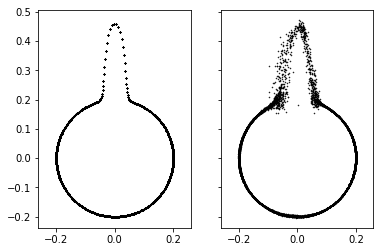

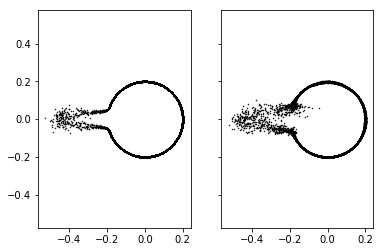

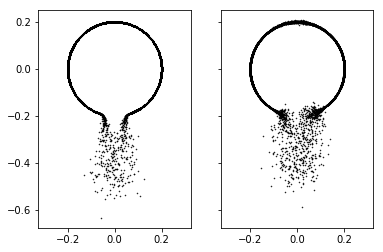

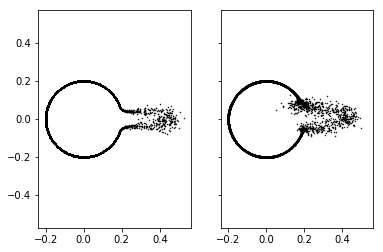

In [85]:
from mock_data import propagate


one_direction = True

reward.eval()
variance.eval()
for action_angle in [np.pi / 2, np.pi, -np.pi / 2, 0.0]:
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    od = 0.2
    ad = 0.4
    mass = 0.05
    size = 0.1
    friction = 0.05
    n_samples = 400
    xs = np.zeros((n_samples, 2))
    X = torch.zeros(n_samples, 7).cuda()
    U = torch.zeros(n_samples, 4).cuda()
    #action_angle = -np.pi / 2
    for i, θ in enumerate(np.linspace(-np.pi, np.pi, n_samples)):
        X[i, :] = torch.cuda.FloatTensor([[od * np.cos(θ), od * np.sin(θ), 0.0, size, size, mass, friction]])
        if one_direction:
            U[i, :] = torch.cuda.FloatTensor([[ad * np.cos(action_angle), ad * np.sin(action_angle), 0.0, 0.6]])
        else:
            U[i, :] = torch.cuda.FloatTensor([[ad * np.cos(θ), ad * np.sin(θ), 0.0, 0.6]])
        xs[i, 0] = od * np.cos(θ)
        xs[i, 1] = od * np.sin(θ)
    y_delta = norminv_y(reward(norm_x(Variable(X)), norm_u(Variable(U)))).cpu().data.numpy()
    mean = X.cpu().numpy()[:, :2] + y_delta[:, :2]
    std = norminv_y(variance(norm_x(Variable(X)), norm_u(Variable(U))) ** 0.5).cpu().data.numpy()
    for _ in range(16):
        ax[1].plot(mean[:, 0] + np.random.randn(n_samples) * std[:, 0], mean[:, 1] + np.random.randn(n_samples) * std[:, 1], 'k.', markersize=1.0)
    #ax[1].plot(xs[:, 0], xs[:, 1], 'k.', markersize=1.0)
    ax[1].axis('equal')

    xs = np.zeros((n_samples, 2))
    for i, θ in enumerate(np.linspace(0, 2 * np.pi, n_samples)):
        obj = np.array([[np.cos(θ) * od, np.sin(θ) * od, 0.0, mass, friction, size, size]] * 16) 
        if one_direction:
            action = np.array([[np.cos(action_angle) * ad, np.sin(action_angle) * ad, 0.0, 0.6]] * 16) 
        else:
            action = np.array([[np.cos(θ) * ad, np.sin(θ) * ad, 0.0, 0.6]] * 32) 
        ys = propagate(obj, action)
        obj_ = obj[:, :3] + ys
        xs[i, :] = np.array([obj[0, 0], obj[0, 1]])
        ax[0].plot(obj_[:, 0], obj_[:, 1], 'k.', markersize=1.0)
    #ax[0].plot(xs[:, 0], xs[:, 1], 'k')
    ax[0].axis('equal')
    plt.show()


In [21]:
with open('notebook_models/mock/reward.pt', 'rb') as f:
    reward.load_state_dict(pickle.load(f))
with open('notebook_models/mock/variance.pt', 'rb') as f:
    variance.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norm_x.pt', 'rb') as f:
    norm_x.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norm_u.pt', 'rb') as f:
    norm_u.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norm_y.pt', 'rb') as f:
    norm_y.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norminv_x.pt', 'rb') as f:
    norminv_x.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norminv_u.pt', 'rb') as f:
    norminv_u.load_state_dict(pickle.load(f))
with open('notebook_models/mock/norminv_y.pt', 'rb') as f:
    norminv_y.load_state_dict(pickle.load(f))

In [270]:
with open('notebook_models/mock/reward.pt', 'wb') as f:
    pickle.dump(reward.state_dict(), f)
with open('notebook_models/mock/variance.pt', 'wb') as f:
    pickle.dump(variance.state_dict(), f)
with open('notebook_models/mock/norm_x.pt', 'wb') as f:
    pickle.dump(norm_x.state_dict(), f)
with open('notebook_models/mock/norm_u.pt', 'wb') as f:
    pickle.dump(norm_u.state_dict(), f)
with open('notebook_models/mock/norm_y.pt', 'wb') as f:
    pickle.dump(norm_y.state_dict(), f)
with open('notebook_models/mock/norminv_x.pt', 'wb') as f:
    pickle.dump(norminv_x.state_dict(), f)
with open('notebook_models/mock/norminv_u.pt', 'wb') as f:
    pickle.dump(norminv_u.state_dict(), f)
with open('notebook_models/mock/norminv_y.pt', 'wb') as f:
    pickle.dump(norminv_y.state_dict(), f)

In [77]:
dataset.max()

x0        0.000000
x1        0.000000
x2        0.000000
y0        0.599789
y1        0.599580
y2        3.141588
x_0       0.599949
x_1       0.599259
x_2       0.599999
y_0       0.709763
y_1       0.635370
y_2       6.869661
u0        0.599949
u1        0.599259
u2        0.599999
u3        0.599995
u4        4.731758
w         0.100000
h         0.100000
m         0.399999
I         4.490673
µ         0.400000
type    666.000000
dtype: float64

In [95]:
class Policy(torch.nn.Module):
    
    def __init__(self, x_size, g_size, u_size, hidden_size=64):
        super(Policy, self).__init__()
        self.fc1 = torch.nn.Linear(x_size + g_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_xy_vel = torch.nn.Linear(hidden_size, 1)
        self.fc_xy_dir = torch.nn.Linear(hidden_size, 2)
        self.fc_r_vel = torch.nn.Linear(hidden_size, 1)
        self.fc_dur = torch.nn.Linear(hidden_size, 1)
        self.register_buffer(
            'xy_vel_scale',
            torch.FloatTensor([0.6])
         )
        self.register_buffer(
            'r_vel_scale',
            torch.FloatTensor([1.4])
         )
        self.register_buffer(
            'dur_scale',
            torch.FloatTensor([0.6])
         )
        
    def forward(self, x, g):
        xg = torch.cat([x, g], dim=1)
        a1 = F.relu(self.fc1(xg))
        a2 = F.relu(self.fc2(a1))
        u_xy_vel = F.sigmoid(self.fc_xy_vel(a2))
        u_xy_dir = F.tanh(self.fc_xy_dir(a2))
        u_r_vel = F.tanh(self.fc_r_vel(a2))
        u_dur = F.sigmoid(self.fc_dur(a2))
        return torch.cat(
            [
                Variable(self.xy_vel_scale) * u_xy_vel * u_xy_dir / u_xy_dir.norm(dim=1, keepdim=True),
                Variable(self.r_vel_scale) * u_r_vel,
                Variable(self.dur_scale) * u_dur,
            ],
            dim=1
        )
        
X, U, Y = next(iter(dataloader_val))
π = Policy(X.size(1), Y.size(1), U.size(1)).cuda()
X, Y = map(lambda x: Variable(x.cuda()), [X, Y])
policy_opt = torch.optim.Adam(π.parameters(), weight_decay=1e-3)
norm_x.cuda()
norm_u.cuda()
norm_y.cuda()

Normalization (
)

In [96]:
time_str = datetime.datetime.now().strftime('%H:%M')
reward.eval()
variance.eval()
logger_policy = SummaryWriter('runs/mock-policy-{}-mse-train'.format(time_str))
step = -1
n_steps = 100000
while True:
    for X, _, Y in dataloader_train:
        π.train()
        π.zero_grad()
        step += 1
        X = Variable(X.cuda())
        Y = Variable(Y.cuda())
        change_goal = Variable(torch.rand(Y.size(0), 1) < 1.5).cuda().float()
        G_normed = norm_y(Y * change_goal) + (1 - change_goal) * Variable(torch.randn(Y.size())).cuda()
        U = π(norm_x(X), G_normed)
        action_regularizer = (U ** 2).sum() / U.size(0)
        loss = expect_distance(norm_x(X), norm_u(U), G_normed).mean()
        loss.backward()
        policy_opt.step()
        logger_policy.add_scalar('cost', loss.cpu().data[0], step)
        if step >= n_steps:
            break
    if step >= n_steps:
        break

Process Process-63:
Process Process-64:
Process Process-61:
Process Process-62:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/isacar/workspace/oracle/mock_data.py", line 82, in __getitem__
    row = next(self.iterator)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/isacar

KeyboardInterrupt: 

  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/isacar/workspace/oracle/mock_data.py", line 89, in __getitem__
    y[-1] = np.arctan2(np.sin(y[-1]), np.cos(y[-1]))
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
KeyboardInterrupt
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
Process Process-57:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/isacar/workspace/oracle/venv/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
Process Proces

In [806]:
with open('notebook_models/policy.pkl', 'wb') as f:
    pickle.dump(π.state_dict(), f)
#with open('notebook_models/policy.pkl', 'rb') as f:
#    π.load_state_dict(pickle.load(f))

In [97]:
class ProductionPolicy(torch.nn.Module):
    
    def __init__(self, norm_x, norm_y, policy):
        super(ProductionPolicy, self).__init__()
        self.norm_x = norm_x
        self.norm_y = norm_y
        self.policy = policy
        
    def forward(self, x, g):
        return self.policy(self.norm_x(x), self.norm_y(g))

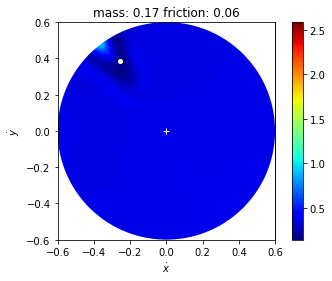

Variable containing:
-0.2554  0.3864 -0.3634  0.5075
[torch.cuda.FloatTensor of size 1x4 (GPU 0)]

In [104]:
production_policy = ProductionPolicy(norm_x, norm_y, π).cuda()
production_policy.eval()
k = -1
obj_x = k * 0.0
obj_y = k * 0.2
goal_x = k * 0.0
goal_y = k * 0.3
width = 0.14
X = Variable(torch.cuda.FloatTensor([[obj_x, obj_y, 0.0, width, width, 0.4, 0.16]]))
G = Variable(torch.cuda.FloatTensor([[goal_x, goal_y, 0.0]]))

#(m    0.427092
# µ    0.168765
# w    0.140528
# h    0.131601
# dtype: float32, m    0.028424
# µ    0.011184
# w    0.009436
# h    0.009934
# dtype: float32)

X, U, G = next(iter(dataloader_val))
X = Variable(X.cuda())
G = Variable(G.cuda())
U = production_policy(X, G)
π = π.cuda()
plot_q(X=X, G=G, π=π)
#print('Rotation:', U.cpu().data[0, -2])
#print('Duration:', U.cpu().data[0, -1])
π(norm_x(X), norm_y(G))[:1, :]

In [823]:
production_policy = production_policy.cpu()
with open('saved_models/production_policy.pkl', 'wb') as f:
    pickle.dump(production_policy.state_dict(), f)
production_policy = production_policy.cuda()

In [23]:
production_policy.cpu()
X, U, Y = next(iter(dataloader_val))
X, U, Y = map(lambda x: Variable(x), [X, U, Y])
Y[0], U[0], production_policy(X, Y)[0]

(Variable containing:
 1.00000e-02 *
   2.1740
  -2.8396
  -3.6060
 [torch.FloatTensor of size 3], Variable containing:
  0.1114
 -0.0344
 -1.3249
  0.1277
 [torch.FloatTensor of size 4], Variable containing:
  0.2101
 -0.1390
 -0.0360
  0.1163
 [torch.FloatTensor of size 4])

In [97]:
def gaussian_likelihood():
    def f(µ, σ, y):
        return (torch.log(σ) + 0.5 * (µ - y) * (µ - y) / (σ ** 2)).sum()
    return f

def multivariate_gaussian_likelihood(µ, L, y):
    """(Average) Negative log-likelihood of a multivariate gaussian.
    
    Notation below:
    n = Number of samples
    k = Dimensionality of gaussian variables

    µ : Variable, dimensions: (n, k)
    L : Lower triangular cholesky decomposition of the covariance matrices, that is LL' = Σ
        dimensions: (n, k, k)
    y : Variable, dimensions: (n, k)
    """
    n, k = µ.size()
    nll = Variable(torch.zeros(1))
    if µ.data.is_cuda:
        nll = nll.cuda()
    for i in range(n):
        l = L[i, :, :]
        L_inv = torch.inverse(l)
        Σ_inv = L_inv.transpose(0, 1) @ L_inv
        d = y[i:i + 1, :] - µ[i:i + 1, :]
        logdet = 2 * torch.log(l.diag()).sum()
        nll += 0.5 * (
            logdet +
            (d @ Σ_inv @ d.transpose(0, 1)).sum() +
            k * np.log(2 * np.pi)
        )
    return nll / n

# Feasibility (MCMC)

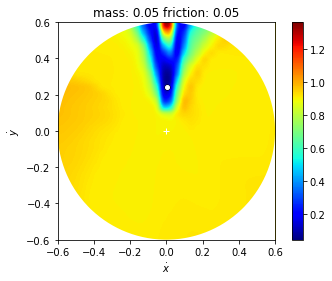

0.04675186797976494

In [244]:
class ExpectedDistanceProduction(torch.nn.Module):
    
    def __init__(self, policy, mean_model=None, variance_model=None, x_norm=None, u_norm=None, y_norm=None):
        super(ExpectedDistanceProduction, self).__init__()
        self.policy = policy
        self.mean = mean_model
        self.variance = variance_model
        self.x_norm = x_norm
        self.u_norm = u_norm
        self.g_norm = y_norm
        self.register_buffer(
            'weights',
            torch.FloatTensor([1.0, 1.0, 0.1])
        )
        
    def forward(self, x, g):
        """
        Variables should not be normalized!
        Goal is relative object! G_rel = (G - X)
        Goal is normalized with same as Y = (X' - X)
        """
        x = self.x_norm(x)
        g = self.g_norm(g)
        u = self.u_norm(self.policy(x, g))
        mean = self.mean(x, u)
        var = self.variance(x, u)
        return ((var + (mean - g) ** 2) * Variable(self.weights)).mean(dim=1)
    
    
edp = ExpectedDistanceProduction(π, mean_model=reward, variance_model=variance, x_norm=norm_x, u_norm=norm_u, y_norm=norm_y).cuda()
#X, U, G = next(iter(dataloader_val))
#X, U, G = map(lambda x: Variable(x.cuda()), [X, U, G])
X = Variable(torch.cuda.FloatTensor([[0.0, 0.2, 0.0, 0.1, 0.1, 0.05, 0.05]]))
G = Variable(torch.cuda.FloatTensor([[0.0, 0.1, 0.0]]))
plot_q(X=X, G=G, π=π)
edp.cpu()
#with open('saved_models/expected_distance.pkl', 'wb') as f:
#    pickle.dump(edp.state_dict(), f)
edp.cuda()
edp(X[:1, :], G[:1, :]).cpu().data[0]

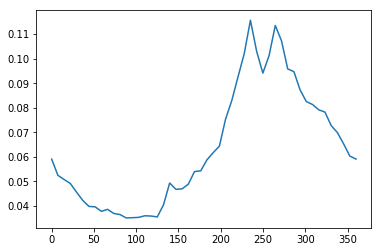

In [269]:
next(iter(dataloader_val))[0]
θs = np.linspace(0, 2 * np.pi)
ys = []
for θ in θs:
    d = 0.2
    gd = 0.1
    X = Variable(torch.cuda.FloatTensor([[np.cos(θ) * d, np.sin(θ) * d, 0.0, 0.1, 0.1, 0.2, 0.2]]))
    G = Variable(torch.cuda.FloatTensor([[np.cos(θ) * gd, np.sin(θ) * gd, 0.0]]))
    ys.append(edp(X, G).cpu().data.numpy()[0])
plt.plot(θs / np.pi * 180, ys)
plt.show()

# Closed form of MCMC

In [115]:
def to_object_centric(X, Y):
    """returns (width, height, mass, friction, dx, dy, dθ), all in object frame"""
    res = torch.zeros(X.size(0), 7)
    res[:, 0] = X[:, 3] # width
    res[:, 1] = X[:, 4] # height
    res[:, 2] = X[:, 5] # mass
    res[:, 3] = X[:, 6] # friction
    θ = X[:, 2]
    res[:, 4] = Y[:, 0] * torch.cos(θ) + Y[:, 1] * torch.sin(θ)
    res[:, 5] = -Y[:, 0] * torch.sin(θ) + Y[:, 1] * torch.cos(θ)
    res[:, -1] = Y[:, -1]
    return res
        
def to_robot_centric(robot, obj):
    """
    Expects (in object centric frame):
    robot : (x_robot, y_robot, θ_robot)
    obj   : (width, height, mass, friction, dx, dy, dθ)
    
    Returns (in robot frame):
    X : (obj_x', obj_y', obj_θ', width, height, mass, friction)
    Y : (dx', dy', dθ')
    """
    X = Variable(torch.zeros(robot.size(0), 7))
    Y = Variable(torch.zeros(robot.size(0), 3))
    if robot.is_cuda:
        X = X.cuda()
        Y = Y.cuda()
    θ = robot[:, 2]
    X[:, 0] = -robot[:, 0] * torch.cos(θ) - robot[:, 1] * torch.sin(θ)
    X[:, 1] = robot[:, 0] * torch.sin(θ) - robot[:, 1] * torch.cos(θ)
    X[:, 2] = torch.atan2(torch.sin(-θ), torch.cos(-θ))
    X[:, 3] = obj[:, 0] # width
    X[:, 4] = obj[:, 1] # height
    X[:, 5] = obj[:, 2] # mass
    X[:, 6] = obj[:, 3] # friction
    Y[:, 0] = obj[:, 4] * torch.cos(θ) + obj[:, 5] * torch.sin(θ)
    Y[:, 1] = -obj[:, 4] * torch.sin(θ) + obj[:, 5] * torch.cos(θ)
    Y[:, 2] = obj[:, 6]
    return X, Y

In [116]:
X, U, Y = next(iter(dataloader_train))
X[0]


 0.1724
-0.2238
 1.0994
 0.0352
 0.0352
 0.3465
 0.0179
[torch.FloatTensor of size 7]

angle: 171.67657256183873 gradient: [ 0.        -0.        -3.6490881]


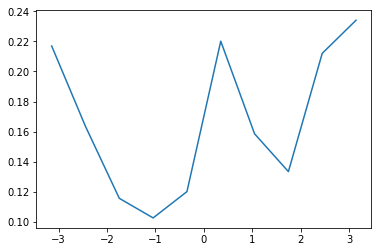

angle: 171.3351314052298 gradient: [ 0.       -0.       -3.494185]


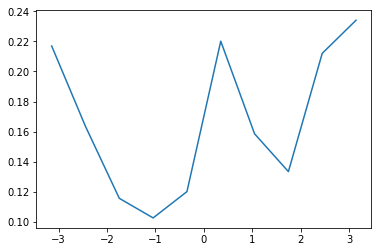

angle: 170.8685611830262 gradient: [ 0.        -0.        -3.0474086]


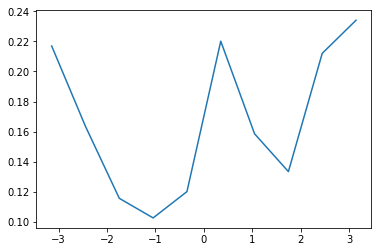

angle: 170.29285819826416 gradient: [ 0.       -0.       -2.552414]


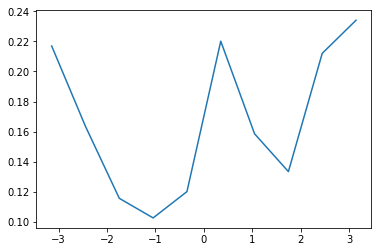

angle: 169.625753622029 gradient: [ 0.        -0.        -2.2380714]


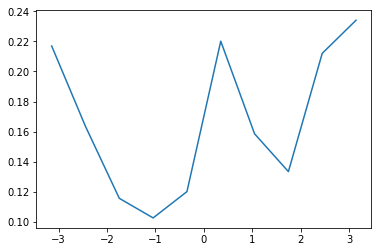

angle: 168.87850360607294 gradient: [ 0.        -0.        -0.9851244]


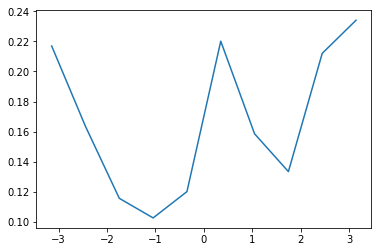

angle: 168.09598249324293 gradient: [-0.         -0.          0.11883897]


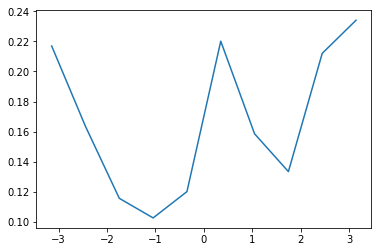

angle: 167.31772341845502 gradient: [-0.        -0.         0.4882524]


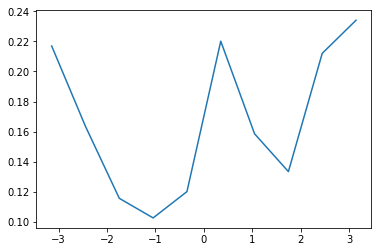

angle: 166.55693596756396 gradient: [-0.         -0.          0.63566554]


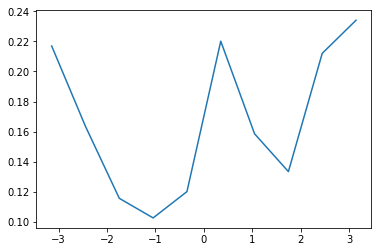

angle: 165.81892036736573 gradient: [-0.         -0.          0.14246693]


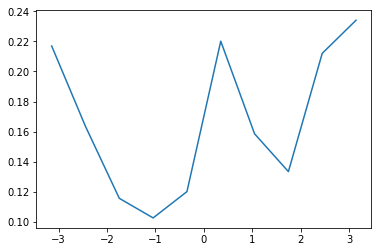

angle: 165.08600008828836 gradient: [-0.         -0.          0.33573496]


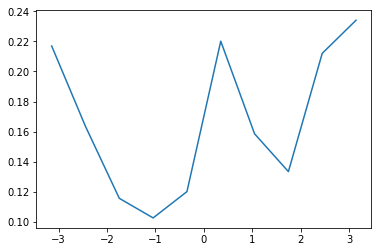

angle: 164.36510094215018 gradient: [-0.        -0.         0.6133507]


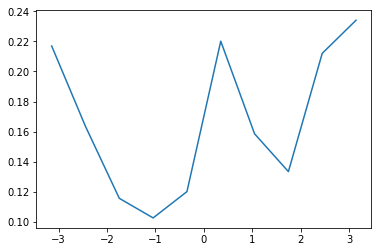

angle: 163.6661676843828 gradient: [-0.         -0.          0.85019714]


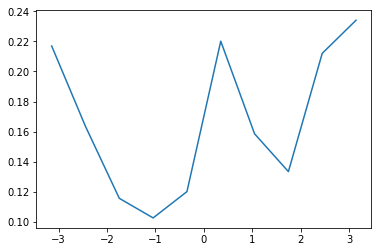

angle: 162.9976834099353 gradient: [ 0.        -0.        -0.9498746]


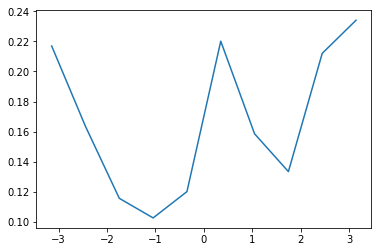

angle: 162.29518479342116 gradient: [ 0.        -0.        -0.8403344]


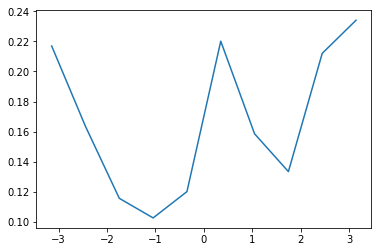

angle: 161.56260602380226 gradient: [ 0.        -0.        -0.7381923]


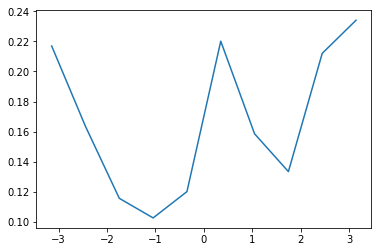

angle: 160.8035807617171 gradient: [-0.         -0.         -0.65298426]


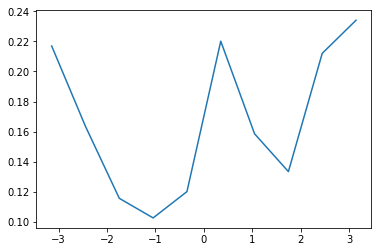

angle: 160.0211689319138 gradient: [-0.        -0.        -0.5701924]


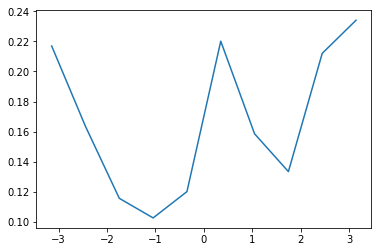

angle: 159.21833483649215 gradient: [ 0.         -0.         -0.75141877]


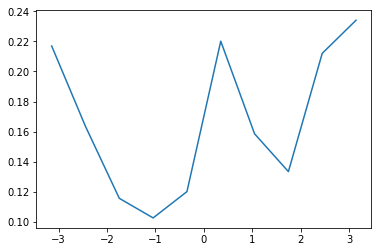

angle: 158.388603456119 gradient: [-0.        -0.         1.5861045]


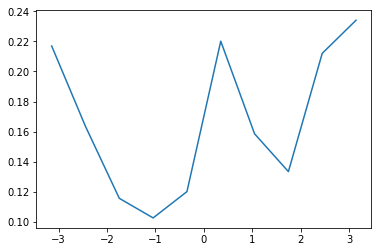

In [268]:
class ObjectCentric2Energy(torch.nn.Module):
    
    def __init__(self, expected_distance_production):
        super(ObjectCentric2Energy, self).__init__()
        self.edp = expected_distance_production
        
    def forward(self, rob, obj):
        X, Y = to_robot_centric(rob, obj)
        U = edp(X, Y)
        return U
    
def grad_U(rob, obj, model):
    model.zero_grad()
    U = model(rob, obj)
    grad, = torch.autograd.grad([U[i:i+1] for i in range(U.size(0))],
                                rob)
    return grad * Variable(torch.cuda.FloatTensor([0.0, 0.0, 10.0]))
    

def next_robot(rob, obj, energy_fn):
    """
    rob : torch.FloatTensor
    obj : torch.FloatTensor
    """
    obj = Variable(obj)
    rob_np = rob.cpu().numpy().copy()
    p_np = np.random.randn(*rob_np.shape) * np.array([0.0, 0.0, 1.0])
    current_q = Variable(torch.FloatTensor(rob_np), requires_grad=True)
    q = Variable(torch.FloatTensor(rob_np), requires_grad=True)

    L = 20
    epsilon = 0.5 / L

    # start HMC (http://www.mcmchandbook.net/HandbookChapter5.pdf p. 125)

    current_p = Variable(torch.FloatTensor(p_np))
    p = Variable(torch.FloatTensor(p_np))
    
    if rob.is_cuda:
        q = q.cuda()
        p = p.cuda()
        current_q = current_q.cuda()
        current_p = current_p.cuda()
    
    # Make half a step for momentum at the beginning
    p = p - epsilon * grad_U(q, obj, energy_fn) / 2

    for l in range(L):
        q.data += epsilon * p.data
        q.data[:, -1] = torch.atan2(torch.sin(q.data[:, -1]), torch.cos(q.data[:, -1]))
        
        # debug 
        angle = np.arctan2(np.sin(q.data[0, 2]), np.cos(q.data[0, 2]))
        print('angle:', angle / np.pi * 180, end=' ')
        hue = (angle + np.pi) / (2 * np.pi)
        color_str = hsv_to_rgb((hue, 1, 1.0))
        #plt.plot(q.data[0, 0], q.data[0, 1], 'o', color=color_str, markersize=2.0, alpha=l / L)
        
        grad = grad_U(q, obj, energy_fn)
        print('gradient:', -grad.cpu().data.numpy().flatten())
        
        # plot energy function for different angles
        q_ = current_q.clone()
        θs = np.linspace(-np.pi, np.pi, 10)
        qs = []
        for θ in θs:
            q_[0, -1] = θ
            e = energy_fn(q_, obj)
            qs.append(e.cpu().data.numpy()[0])
        plt.plot(θs, qs)
        plt.show()
        
        if l < L - 1:
            p = p - epsilon * grad

    # Make half a step for momentum at the end
    p = p - epsilon * grad_U(q, obj, energy_fn) / 2
    p = -p

    current_U = energy_fn(current_q, obj)
    current_K = (current_p ** 2).sum(dim=1) / 2.0
    proposed_U = energy_fn(q, obj)
    proposed_K = (p ** 2).sum(dim=1) / 2.0
    
    # Acceptance probability
    ones = Variable(torch.ones(current_U.size()))
    if rob.is_cuda:
        ones = ones.cuda()
    T = 1e-1
    prob = torch.min(
        ones,
        torch.exp((current_U - proposed_U) / T + (current_K - proposed_K) / T))
    mask = torch.bernoulli(prob)
    res = q * mask.view(-1, 1) + current_q * (1 - mask).view(-1, 1)
    return res.data

    
edp.eval()
energy = ObjectCentric2Energy(edp.cuda())
energy = energy.cuda()

def iter_hmc_samples(dataloader, samples_per_setup=64):
    while True:
        for X, _, Y in dataloader:
            O = to_object_centric(X, Y)
            R = torch.randn(O.size(0), 3) * torch.FloatTensor([0.01, 0.01, 3])
            R[:, -1] = torch.atan2(torch.sin(R[:, -1]), torch.cos(R[:, -1]))
            O = O.cuda()
            R = R.cuda()

            n_burn_in = 32
            for i in range(samples_per_setup + n_burn_in):
                R = next_robot(R, O, energy)
                if i < n_burn_in:
                    continue
                R_ = torch.zeros(R.size(0), 4)
                R_[:, :2] = R[:, :2]
                R_[:, -2] = torch.cos(R[:, -1])
                R_[:, -1] = torch.sin(R[:, -1])
                yield O, R_
                
plt.close()
o = torch.cuda.FloatTensor([[0.1, 0.1, 0.05, 0.05, 0.0, 0.1, 0.0]])
#res = 32
#img = np.zeros((res, res))
#rmax = 1.0
#plt.figure(figsize=(8, 8))
#for i, rx in enumerate(np.linspace(-rmax, rmax, res)):
#    for j, ry in enumerate(np.linspace(-rmax, rmax, res)):
#        r = torch.cuda.FloatTensor([[rx, ry, 0.0]])
#        img[j, i] = energy(Variable(r), Variable(o)).cpu().data[0]
#plt.imshow(img, interpolation='gaussian', origin='lower', extent=[-rmax, rmax, -rmax, rmax])

samples = []
for _ in range(1):
    r = (torch.randn(1, 3) * torch.FloatTensor([0.01, 0.01, 3])).cuda()
    r = torch.FloatTensor([[0.0, -0.1, 3]]).cuda()
    n_burn_in = 1
    for i in range(n_burn_in + 0):
        r = next_robot(r, o, energy)
        if i >= n_burn_in:
            r_np = r.cpu().numpy().flatten()
            samples.append(r_np)
            
#for x, y, θ in samples:
#    hue = min(1, max(0, (θ + np.pi) / (2 * np.pi)))
#    plt.plot(x, y, '.', markersize=6.0, color=hsv_to_rgb((hue, 1, 1.0)))
#plt.xlim(-1.0, 1.0)
#plt.ylim(-1.0, 1.0)
#plt.grid()
#plt.show()

#dataset_feasibility = []
#
#logger = SummaryWriter('./runs/half-circle-data-gen')
#
#for i, (o, r) in enumerate(iter_hmc_samples(dataloader_train)):
#    o_np = [o_ for o_ in o.cpu().numpy()]
#    r_np = [r_ for r_ in r.cpu().numpy()]
#    dataset_feasibility.extend(zip(o_np, r_np))
#    logger.add_scalar('progress', i / (32 * 128), i)
#    if i >= 32 * 128 - 1:
#        break

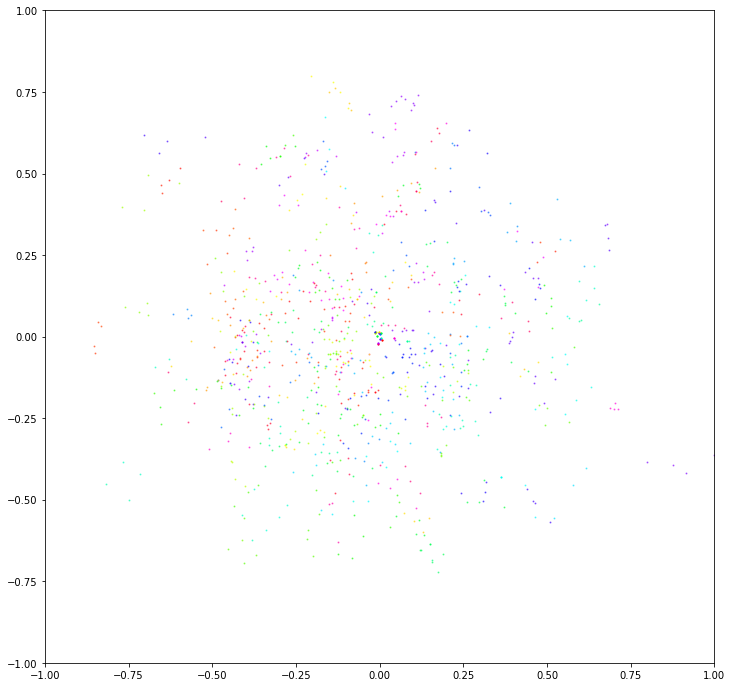

98304

In [186]:
plt.close()
plt.figure(figsize=(12, 12))
for o, r in dataset_feasibility[:1000]:
    θ = np.arctan2(r[-1], r[-2])
    hue = (θ + np.pi) / (2 * np.pi)
    if np.linalg.norm(o[2:4]) > 0.05:
        plt.plot(r[0], r[1], 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=1.0, alpha=0.5)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.show()
len(dataset_feasibility)

In [187]:
with open('./dataset_feasibility_dot.pkl', 'wb') as f:
    pickle.dump(dataset_feasibility, f)
#with open('./dataset_feasibility.pkl', 'rb') as f:
#    dataset_feasibility = pickle.load(f)
len(dataset_feasibility)

98304

In [352]:
# obj   : (width, height, mass, friction, dx, dy, dθ)
# robot : (x_robot, y_robot, θ_robot)
np.array([sample[0] for sample in dataset_feasibility[:1000]]).std(axis=0).reshape(1, -1)
np.array([sample[1] for sample in dataset_feasibility[:1000]]).max(axis=0).reshape(1, -1)

array([[0.73313516, 0.9754211 , 0.9999975 , 0.99999577]], dtype=float32)

In [64]:
# Normalize target distribution
robot_norm = Normalization(4)
robot_norm.std = torch.cuda.FloatTensor([0.73, 1.0, 1.0, 1.0]) # picked by eyeballing

robot_norminv = NormalizationInverse(4)
robot_norminv.std = robot_norm.std

robot_norm = robot_norm.cuda()
robot_norminv = robot_norminv.cuda()

# Normalize input data
obs_norm = Normalization(7)
obs_mean = np.array([sample[0] for sample in dataset_feasibility[:1000]]).mean(axis=0)
obs_std = np.array([sample[0] for sample in dataset_feasibility[:1000]]).std(axis=0)
obs_norm.mean = torch.from_numpy(obs_mean).float().cuda()
obs_norm.std = torch.from_numpy(obs_std).float().cuda()

obs_norminv = NormalizationInverse(7)
obs_norminv.mean = obs_norm.mean
obs_norminv.std = obs_norm.std

obs_norm = obs_norm.cuda()
obs_norminv = obs_norminv.cuda()

In [65]:
class FeasibilityGenerator(torch.nn.Module):
    
    def __init__(self):
        super(FeasibilityGenerator, self).__init__()
        observation_size = 7
        output_size = 4
        self.latent_size = 5
        hidden_size = 512
        input_size = self.latent_size + observation_size
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.norm2 = torch.nn.BatchNorm1d(hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.norm3 = torch.nn.BatchNorm1d(hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.norm4 = torch.nn.BatchNorm1d(hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fcy = torch.nn.Linear(hidden_size, output_size)
        self.train()
    
    def forward(self, obj):
        """
        Expects obj: (width, height, dx, dy, dθ)
        """
        z = Variable(torch.randn(obj.size(0), self.latent_size))
        if obj.is_cuda:
            z = z.cuda()
        inputs = torch.cat([obj, z], dim=1)
        y1 = self.fc1(inputs)
        y2 = self.fc2(F.relu(self.norm2(y1))) + y1
        y3 = self.fc3(F.relu(self.norm3(y2))) + y2
        y4 = self.fc4(F.relu(self.norm4(y3))) + y3
        y = F.tanh(self.fcy(y4))
        return y


class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        input_size = 7 + 4
        hidden_size = 512
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fcy = torch.nn.Linear(hidden_size, 1)
        self.train()
        
    def forward(self, obj, rob):
        inputs = torch.cat([obj, rob], dim=1)
        y1 = self.fc1(inputs)
        y2 = self.fc2(F.relu(y1)) + y1
        y3 = self.fc3(F.relu(y2)) + y2
        y4 = self.fc4(F.relu(y3)) + y3
        logit = self.fcy(y4)
        y = F.sigmoid(logit)
        return logit, y
    
generator = FeasibilityGenerator()

In [66]:
def configure_latex():
    """ 
        Configure matplotlib to use latex in a pretty way
    """
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': 'Palatino',
        'font.size': 12, 
        'legend.fontsize': 14, 
        'legend.labelspacing': 0,
        'text.usetex': True,
        'savefig.dpi': 300})


def simplify_axis(axis):
    """ 
        Simplify axis
    """
    axis.set_frame_on(False)
    xmin, xmax = axis.get_xaxis().get_view_interval()
    ymin, ymax = axis.get_yaxis().get_view_interval()
    axis.add_artist(plt.Line2D((xmin, xmin), (ymin, ymax), color='black',
                               linewidth=1, zorder=100, clip_on=False))
    axis.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black',
                               linewidth=1, zorder=100, clip_on=False))
    axis.get_yaxis().tick_left()
    axis.get_xaxis().tick_bottom()


def save_fig(fig_name, width=9, height=5):
    """ 
        Save the current figure under filename fig_name
    """
    plt.gcf().set_size_inches((width, height))
    simplify_axis(plt.gca())
    plt.savefig(fig_name, bbox_inches='tight', pad_inches=0.02)
    plt.close()
    
configure_latex()

In [67]:
dataset.head()

,x0,x1,x2,y0,y1,y2,x_0,x_1,x_2,y_0,...,u1,u2,u3,u4,w,h,m,I,µ,type
0,0.0,0.0,0.0,-0.644718,0.021560,-0.107753,0.098387,0.125339,-0.683724,-0.644718,...,0.144045,-0.78124,0.319778,0.0,0.1,0.1,0.01,0.000067,0.05,box
1,0.0,0.0,0.0,-0.667137,0.000733,-0.067803,0.098387,0.125339,-0.683724,-0.667137,...,0.144045,-0.78124,0.319778,0.5,0.1,0.1,0.01,0.000067,0.05,box
2,0.0,0.0,0.0,-0.656261,0.010888,-0.198265,0.098387,0.125339,-0.683724,-0.656261,...,0.144045,-0.78124,0.319778,0.0,0.1,0.1,0.01,0.000067,0.05,box
3,0.0,0.0,0.0,-0.659638,0.001323,-0.196596,0.098387,0.125339,-0.683724,-0.659638,...,0.144045,-0.78124,0.319778,0.5,0.1,0.1,0.01,0.000067,0.05,box
4,0.0,0.0,0.0,-0.667985,0.016803,-0.019249,0.098387,0.125339,-0.683724,-0.667985,...,0.144045,-0.78124,0.319778,0.0,0.1,0.1,0.01,0.000067,0.05,box


64


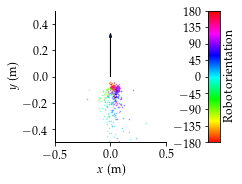

65


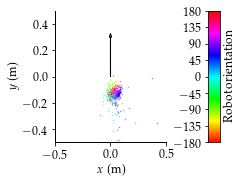

66


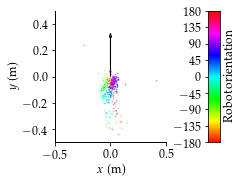

67


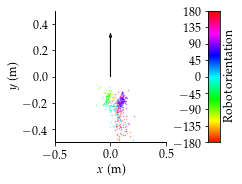

68


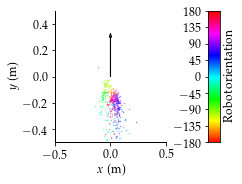

69


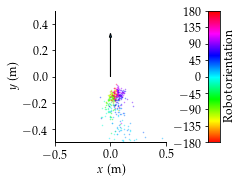

70


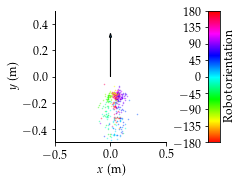

71


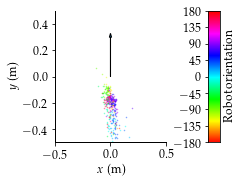

72


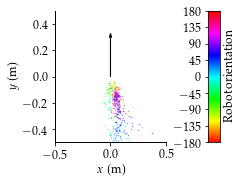

73


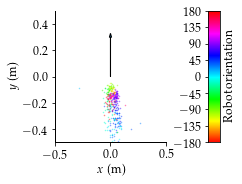

74


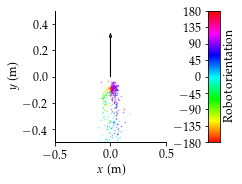

75


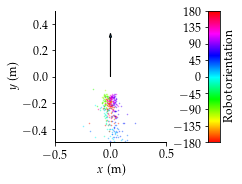

76


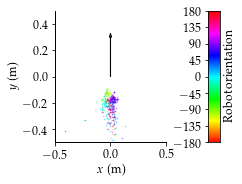

77


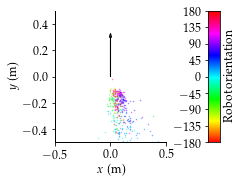

78


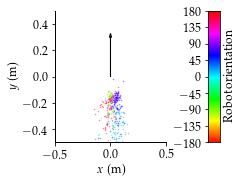

79


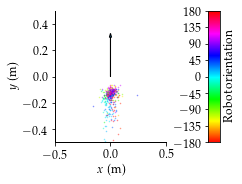

80


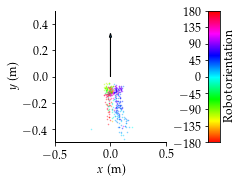

81


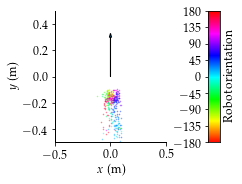

82


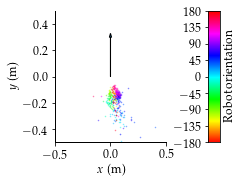

83


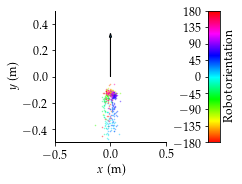

84


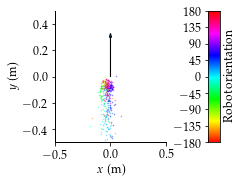

85


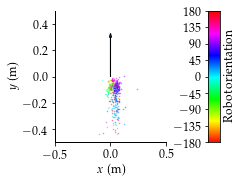

86


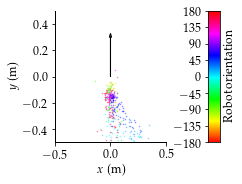

87


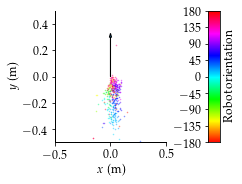

88


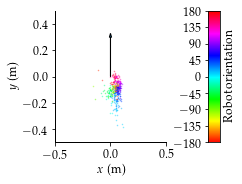

89


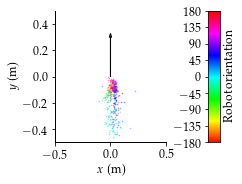

90


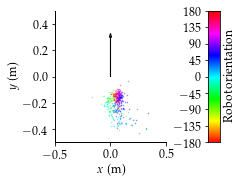

91


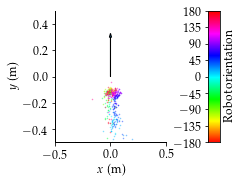

92


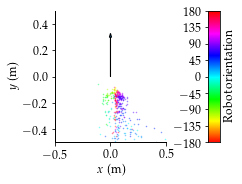

93


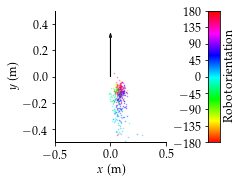

94


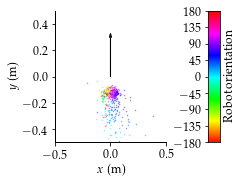

95


FileNotFoundError: [Errno 2] No such file or directory: './generator_models/half_c_model_95000.pkl'

In [71]:
def plot_generator(generator, iteration, path=None, k=0.5):
    generator.eval()
    n = 400
    os = [
        Variable(torch.FloatTensor([[0.1, 0.1, 0.01, 0.05, 1.00 * 0, 1.00 * k, 0.0]]).cuda().repeat(n, 1)),
        Variable(torch.FloatTensor([[0.13, 0.13, 0.1, 0.1, 1.00 * k, 1.00 * 0, 0.0]]).cuda().repeat(n, 1)),
        Variable(torch.FloatTensor([[0.13, 0.13, 0.1, 0.1, 1.00 * 0,-1.00 * k, 0.0]]).cuda().repeat(n, 1)),
        Variable(torch.FloatTensor([[0.13, 0.13, 0.1, 0.1,-1.00 * k, 1.00 * 0, 0.0]]).cuda().repeat(n, 1)),
    ]
    fig, axs = plt.subplots(1, 2, figsize=(3, 2.5), gridspec_kw={'width_ratios': [1, 0.1]})
    axs = axs.flatten()
    plt.tight_layout()
    for i in range(1):
        O = obs_norm(os[i])
        r = robot_norminv(generator(O)).cpu().data.numpy()
        for j in range(r.shape[0]):
            θ = np.arctan2(r[j, -1], r[j, -2])
            hue = (θ + np.pi) / (2 * np.pi)
            hue = (hue + 0.25) % 1.0
            axs[i].plot(r[j, 0], r[j, 1], 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=0.5, alpha=0.5)
        axs[i].arrow(0, 0, os[i].data[0, 4], os[i].data[0, 5], head_width=0.02)
        axs[i].set_xlim(-0.5, 0.5)
        axs[i].set_ylim(-0.5, 0.5)
        axs[i].set_xlabel('$x$ (m)')
        simplify_axis(axs[i])
    axs[0].set_ylabel('$y$ (m)')
        
    # degree bar
    for θ in np.linspace(-np.pi, np.pi, 640):
        hue = (θ + np.pi) / (2 * np.pi)
        axs[1].plot([0, 0.1], [θ / np.pi * 180] * 2, color=hsv_to_rgb((hue, 1, 1.0)), markersize=1)
    axs[1].set_ylim([-180, 180])
    axs[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    axs[1].set_xticks([])
    axs[1].set_ylabel('Robot orientation')
    axs[1].yaxis.set_label_position("right")
    
    if path:
        save_fig(path, width=3, height=2.5)
        plt.show()
    else:
        plt.show()
    generator.train()

plt.close()
for i in range(64, 100):
    print(i)
    with open('./generator_models/half_c_model_{}000.pkl'.format(i), 'rb') as f:
        state_dict = torch.load(f)
    generator.load_state_dict(state_dict)
    generator = generator.cuda()
    #plot_generator(generator, 30000, k=0.3, path='noisy_gan_samples_hc.pdf')
    plot_generator(generator, 30000, k=0.3)

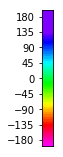

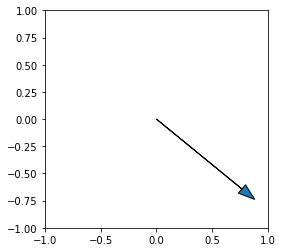

In [942]:
plt.figure(figsize=(0.2, 2.5))
for θ in np.linspace(-np.pi, np.pi):
    hue = (θ + np.pi) / (2 * np.pi)
    hue = (hue - 0.25) % 1.0
    plt.plot(0, θ / np.pi * 180, 'o', color=hsv_to_rgb((hue, 1, 1.0)), markersize=32)
plt.yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
plt.xticks([])
plt.show()
test_angle = -130
θ = test_angle / 180 * np.pi
plt.figure(figsize=(4, 4))
plt.arrow(0.0, 0.0, -np.sin(θ), np.cos(θ), head_width=0.1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()


step: 0


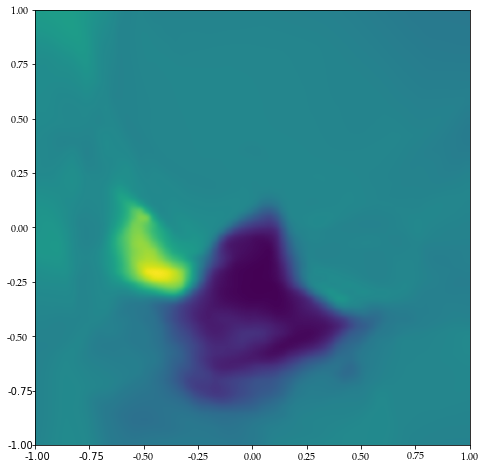

step: 1000
step: 2000
step: 3000
step: 4000
step: 5000
step: 6000
step: 7000
step: 8000
step: 9000
step: 10000
step: 11000
step: 12000
step: 13000
step: 14000
step: 15000
step: 16000
step: 17000
step: 18000
step: 19000
step: 20000
step: 21000
step: 22000
step: 23000
step: 24000
step: 25000
step: 26000
step: 27000
step: 28000
step: 29000
step: 59000
step: 60000
step: 61000
step: 62000
step: 63000
step: 64000
step: 65000
step: 66000
step: 67000
step: 68000
step: 69000
step: 70000
step: 71000
step: 72000
step: 73000
step: 74000
step: 75000
step: 76000
step: 77000
step: 78000
step: 79000
step: 80000
step: 81000
step: 85000
step: 87000
step: 88000
step: 89000
step: 91000


In [ ]:
lr = 1e-4
gamma = 1
batch_size = 256
n_steps = 100000

generator = FeasibilityGenerator().cuda()
generator_opt = torch.optim.RMSprop(generator.parameters(), lr=lr, weight_decay=1e-2)

discriminator = Discriminator().cuda()
discriminator_opt = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

dataloader_feasibility = DataLoader(dataset_feasibility, batch_size=batch_size, shuffle=True, drop_last=True)
logger = SummaryWriter('./runs/noisy-gan')

replay_dataset = []
replay_dataloader = DataLoader(replay_dataset, batch_size=batch_size, shuffle=True)
generator.train()
discriminator.train()

models = dict()

all_parameters = list(generator.parameters())
all_parameters.extend(discriminator.parameters())

labels_real = Variable(torch.ones(batch_size, 1)).cuda()
labels_fake = Variable(torch.zeros(batch_size, 1)).cuda()

step = -1

i = 64000
    
while True:
    for O, R in dataloader_feasibility:
        R = R.clamp(-1, 1)
        step += 1
        R = robot_norm(Variable(R.cuda()))
        O = obs_norm(Variable(O.cuda()))

        # Train discriminator
        # - train real
        discriminator.zero_grad()
        logits, D = discriminator(O, o)
        logit_regularizer = (logits ** 2).sum() / batch_size
        loss_discriminator = -torch.log(D + 1e-6).mean()
        loss_d_real = loss_discriminator + logit_regularizer
        if step % 50 == 0:
            logger.add_scalar('discriminator real mean', D.mean().cpu().data[0], step)
        loss_d_real.backward()
        discriminator_opt.step()
        
        # - train fake
        discriminator.zero_grad()
        R_ = generator(O)
        if len(replay_dataset) > 0 and np.random.rand() < 0.5:
            o, r = next(iter(replay_dataloader))
            O_replay = Variable(o.cuda())
            R_ = Variable(r.cuda())
            logits, D = discriminator(O_replay, R_.detach())
        else:
            logits, D = discriminator(O, R_.detach())
        logit_regularizer = (logits ** 2).sum() / batch_size
        loss_discriminator = torch.log(D + 1e-6).mean()
        loss_d_real = loss_discriminator + logit_regularizer
        if step % 50 == 0:
            logger.add_scalar('discriminator fake mean', D.mean().cpu().data[0], step)
        loss_d_real.backward()
        discriminator_opt.step()

        # Train generator
        generator.zero_grad()
        R_ = generator(O)
        replay_dataset.extend(list(zip(O.data, R.data)))
        logits, D = discriminator(O, R_)
        loss_generator = -torch.log(D + 1e-6).mean()
        loss_generator.backward()
        generator_opt.step()
        
        if step % 1000 == 0:
            print('step:', step)
            plot_generator(generator, step, k=0.3, path='noisy_circle/sample_{}.pdf'.format(step))
            with open('./generator_models/noisy_model_{}.pkl'.format(step), 'wb') as f:
                torch.save(generator.state_dict(), f)

        if step == n_steps - 1:
            break
    if step == n_steps - 1:
        break

In [897]:
class GeneratorProduction(torch.nn.Module):
    
    def __init__(self):
        super(GeneratorProduction, self).__init__()
        self.generator = FeasibilityGenerator()
        self.obj_norm = Normalization(7)
        self.rob_norminv = NormalizationInverse(4)
    
    def forward(self, obj, obj_delta):
        """
        obj       : (width, height, mass, friction, x_obj, y_obj, θ_obj)
        obj_delta : (dx, dy, dθ)
        """
        # obj_delta' is the delta in object frame
        obj_delta_ = Variable(torch.zeros(obj.size(0), 7))
        θ = obj[:, -1]
        obj_delta_[:, :4] = obj[:, :4]
        obj_delta_[:, 4] =  torch.cos(θ) * obj_delta[:, 0] + torch.sin(θ) * obj_delta[:, 1]
        obj_delta_[:, 5] = -torch.sin(θ) * obj_delta[:, 0] + torch.cos(θ) * obj_delta[:, 1]
        obj_delta_[:, 6] = obj_delta[:, -1]
        y = self.rob_norminv(self.generator(self.obj_norm(obj_delta_)))
        y[:, 2] = torch.atan2(y[:, 3], y[:, 2])
        # invariant: y is now robot position in object frame
        # convert to robot frame
        y_rob = Variable(torch.zeros(obj.size(0), 3))
        y_rob[:, 0] = obj[:, 4] + torch.cos(θ) * y[:, 0] - torch.sin(θ) * y[:, 1]
        y_rob[:, 1] = obj[:, 5] + torch.sin(θ) * y[:, 0] + torch.cos(θ) * y[:, 1]
        θr = y[:, 2] + θ
        y_rob[:, 2] = torch.atan2(torch.sin(θr), torch.cos(θr))
        return y_rob
    

generator_production = GeneratorProduction()
generator_production.generator.load_state_dict(generator.state_dict())
generator_production.obj_norm.load_state_dict(obs_norm.state_dict())
generator_production.rob_norminv.load_state_dict(robot_norminv.state_dict())
generator_production = generator_production.cpu()
generator_production.eval()

o = Variable(torch.FloatTensor([[0.13, 0.13, 0.1, 0.1, 0.3, 0.0, np.pi / 2]]))
do = Variable(torch.FloatTensor([[-0.3, 0.0, 0.0]]))
y = generator_production(o, do).data.numpy().flatten()

with open('saved_models/generator_production.pkl', 'wb') as f:
    pickle.dump(generator_production.state_dict(), f)

In [493]:
generator.load_state_dict()

1.9007963267948966

# Pushability

$$p(x_t'|x_t)$$

## Datasets

In [ ]:
# sort in order
dataset_pushability = dataset[['y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']] # skip u_4 because always 0
dataset_pushability = dataset_pushability[(dataset_pushability[['y\'_0', 'y\'_1', 'y\'_2']].abs().max(axis=1) > 1e-1)]
# Decide where to split in training/validation/test
train_cut = int(len(dataset_pushability) * 0.9)
valid_cut = train_cut + int(len(dataset_pushability) * 0.05)
dataset_pushability_train_ = dataset_pushability[:train_cut]
dataset_pushability_val_ = dataset_pushability[train_cut:valid_cut]
dataset_pushability_test_ = dataset_pushability[valid_cut:]

## Normalize by training set statistics
training_pushability_µ = dataset_pushability_train_.mean().values.astype(np.float32)
training_pushability_σ = dataset_pushability_train_.std().values.astype(np.float32)
dataset_pushability_train = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_val = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ
dataset_pushability_test = (dataset_pushability_train_ - training_pushability_µ) / training_pushability_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('y\'')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('y\'')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_pushability_train = get_dataloader(dataset_pushability_train)
dataloader_pushability_val = get_dataloader(dataset_pushability_val, batch_size=512)
dataloader_pushability_test = get_dataloader(dataset_pushability_test, batch_size=512)
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

# Models:

In [ ]:
n_residual_units = 1
hidden_size = 256
X, Y = next(iter(dataloader_pushability_train))
x_size = X.size(1)
y_size = Y.size(1)
print('X and Y sizes:', x_size, y_size)
pushability_mean = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size)
).cuda()

pushability_std = torch.nn.Sequential(
    torch.nn.Linear(x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, y_size),
    torch.nn.Softplus()
).cuda()

In [ ]:
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(pushability_mean.parameters(), weight_decay=1e-4)
var_loss_fn = gaussian_likelihood()
var_optim = torch.optim.Adam(pushability_std.parameters(), weight_decay=1e-4)

logger_train = SummaryWriter('runs/resid-1-pushability-train')
logger_valid = SummaryWriter('runs/resid-1-pushability-valid')

In [ ]:
best_val = np.inf
best_mean_model = None
best_var_model = None
step = 0
while True:
    for batch in dataloader_pushability_train:
        pushability_mean.train()
        pushability_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = pushability_mean(X)
        Y_var_pred = pushability_std(X)

        pushability_mean.zero_grad()
        pushability_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = var_loss_fn(Y_mean_pred, Y_var_pred, Y)
        nll.backward()
        var_optim.step()

        if step % 10 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            pushability_mean.eval()
            pushability_std.eval()
            val_batch = next(iter(dataloader_pushability_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = pushability_mean(X)
            Y_var_pred = pushability_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = var_loss_fn(Y_mean_pred, Y_var_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = pushability_mean.state_dict()
                best_var_model = pushability_std.state_dict()

        step += 1
        if step >= 100000:
            break
    if step >= 100000:
        break

In [ ]:
X, Y = next(iter(dataloader_pushability_train))
pushability_x_size, pushability_y_size = X.size(1), Y.size(1)

pushability_norm = Normalization(5)
pushability_norm.mean = torch.from_numpy(training_pushability_μ[3:])
pushability_norm.std = torch.from_numpy(training_pushability_σ[3:])

pushability_norminv = NormalizationInverse(3)
pushability_norminv.mean = torch.from_numpy(training_pushability_μ[:3])
pushability_norminv.std = torch.from_numpy(training_pushability_σ[:3])

In [ ]:
with open('./saved_models/pushability_models.pkl', 'wb') as f:
    model_dict = {
        'mean_model': pushability_mean.state_dict(),
        'std_model': pushability_std.state_dict(),
        'norm': pushability_norm.state_dict(),
        'norm_inv': pushability_norminv.state_dict(),
        'n_features_in': pushability_x_size,
        'n_features_out': pushability_y_size,
        'n_hidden_units': 256,
        'n_residual_units': 1,
    }
    pickle.dump(model_dict, f)

In [ ]:
pushability_mean.eval()
pushability_std.eval()
pushability_mean.load_state_dict(best_mean_model)
pushability_std.load_state_dict(best_var_model)

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
# First set up the figure, the axis, and the plot element we want to animate
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

res = 16
img = np.eye(res)
p1 = axs[0].imshow(img, extent=[-1, 1, -1, 1], vmin=0.0, vmax=0.5, interpolation='gaussian')
std1 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
std2 = axs[0].add_artist(plt.Circle((0, 0), fill=False, color='white'))
axs[0].set_title('Translation')
axs[2].set_title('Parameter')
axs[2].set_xlim(0, 32)
axs[2].set_ylim(0, 2.0)
θ_data = []
θ_plot, = axs[1].plot(θ_data)
axs[1].set_xlim(0, 32)
axs[1].set_ylim(0, 2)
axs[1].set_title('Rotation standard dev.')
ydata = []
argplot, = axs[2].plot(ydata)
    
# animation function. This is called sequentially
def animate(arg):
    x = (np.array([[0.35, 0.0024, 0.195 * arg * 2, 0.12, 0.12]]) - training_pushability_μ[3:]) / training_pushability_σ[3:]
    X = Variable(torch.from_numpy(x.astype(np.float32))).cuda()
    Y_mean_pred = pushability_mean(X).cpu().data.numpy()
    Y_std = pushability_std(X).cpu().data.numpy()
    
    µ = Y_mean_pred[0, :] * training_pushability_σ[:3] + training_pushability_μ[:3]
    σ = Y_std * training_pushability_σ[:3]
    Σ = np.diag(σ.flatten())

    obs = dataset_pushability_train.iloc[0].values[3:].reshape(-1, 1)
    obs[0, 0] = arg
    for i, x in enumerate(np.linspace(-1, 1, res)):
        for j, y in enumerate(np.linspace(-1, 1, res)):
            img[j, i] = multivariate_normal.pdf([x, y, 0], mean=µ.flatten(), cov=Σ)
    p1.set_data(img)
    σ_ = σ[0, :2].mean()
    std1.set_radius(σ_)
    std2.set_radius(σ_ * 2)
    ydata.append(arg)
    θ_data.append(σ[0, 2])
    argplot.set_data(range(len(ydata)), ydata)
    argplot.set_data(range(len(ydata)), ydata)
    θ_plot.set_data(range(len(θ_data)), θ_data)
    
    return p1, std1, std2, argplot, θ_plot

# call the animator. blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, frames=np.linspace(0.0, 2.0, 32), interval=100, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

# Feasibility
Predicts $p(x_{robot}|x_{target}, x_{target}')$

In [ ]:
dataset_feasibility = dataset[['x_0', 'x_1', 'x_2', 'x_3',
                               'y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2',
                               'm', 'I', 'µ', 'w', 'h']]
# Decide where to split in training/validation/test
train_cut = int(len(dataset) * 0.9)
valid_cut = train_cut + int(len(dataset) * 0.05)
dataset_feasibility_train_ = dataset_feasibility[:train_cut]
dataset_feasibility_val_ = dataset_feasibility[train_cut:valid_cut]
dataset_feasibility_test_ = dataset_feasibility[valid_cut:]

# Normalize by training set statistics
training_feasibility_µ = dataset_feasibility_train_.mean()
training_feasibility_σ = dataset_feasibility_train_.std()
dataset_feasibility_train = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_val = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ
dataset_feasibility_test = (dataset_feasibility_train_ - training_feasibility_µ) / training_feasibility_σ

def get_dataloader(dataset, batch_size=32):
    X = dataset[[name for name in dataset.columns if not name.startswith('x')]]
    Y = dataset[[name for name in dataset.columns if name.startswith('x')]]
    return DataLoader(
        list(zip(X.as_matrix().astype(np.float32), Y.as_matrix().astype(np.float32))),
        batch_size=batch_size,
        shuffle=True
    )

dataloader_feasibility_train = get_dataloader(dataset_feasibility_train)
dataloader_feasibility_val = get_dataloader(dataset_feasibility_val, batch_size=128)
dataloader_feasibility_test = get_dataloader(dataset_feasibility_test, batch_size=128)
X, Y = next(iter(dataloader_feasibility_train))
feasibility_x_size, feasibility_y_size = X.size(1), Y.size(1)
dataset_feasibility_train.iloc[:10]

# Models:

In [ ]:
hidden_size = 256
n_residual_units = 1

feasibility_mean = torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size)
).cuda()

feasibility_std= torch.nn.Sequential(
    torch.nn.Linear(feasibility_x_size, hidden_size),
    *[Residual(hidden_size) for _ in range(n_residual_units)],
    torch.nn.Linear(hidden_size, feasibility_y_size),
    torch.nn.Softplus()
).cuda()

In [ ]:
weight_decay = 1e-4
mean_loss_fn = torch.nn.MSELoss()
mean_optim = torch.optim.Adam(feasibility_mean.parameters(), weight_decay=weight_decay)
std_loss_fn = gaussian_likelihood()
std_optim = torch.optim.Adam(feasibility_std.parameters(), weight_decay=weight_decay)

time_str = datetime.datetime.now().strftime('%H:%M')
name = 'runs/feasibility'
logger_train = SummaryWriter(name + '-train')
logger_valid = SummaryWriter(name + '-valid')

In [ ]:
best_val = np.inf
best_mean_model = None
best_std = None
step = 0
for _ in range(1024):
    for batch in dataloader_feasibility_train:
        feasibility_mean.train()
        feasibility_std.train()
        X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), batch)
        Y_mean_pred = feasibility_mean(X)
        Y_std_pred = feasibility_std(X)

        feasibility_mean.zero_grad()
        feasibility_std.zero_grad()

        mse = mean_loss_fn(Y_mean_pred, Y)
        mse.backward(retain_graph=True)
        mean_optim.step()

        nll = std_loss_fn(Y_mean_pred, Y_std_pred, Y)
        nll.backward()
        std_optim.step()

        if step % 500 == 0:
            logger_train.add_scalar('mse', mse.cpu().data.numpy()[0], step)
            logger_train.add_scalar('nll', nll.cpu().data.numpy()[0], step)
            
            feasibility_mean.eval()
            feasibility_std.eval()
            val_batch = next(iter(dataloader_feasibility_val))
            X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
            Y_mean_pred = feasibility_mean(X)
            Y_std_pred = feasibility_std(X)

            mse_val = mean_loss_fn(Y_mean_pred, Y)
            nll_val = std_loss_fn(Y_mean_pred, Y_std_pred, Y).cpu().data.numpy()[0]
            
            logger_valid.add_scalar('mse', mse_val.cpu().data.numpy()[0], step)
            logger_valid.add_scalar('nll', nll_val, step)
            
            if nll_val < best_val:
                best_val = nll_val
                best_mean_model = feasibility_mean.state_dict()
                best_std_model = feasibility_std.state_dict()

        step += 1

In [ ]:
feasibility_norm = Normalization(feasibility_x_size).cuda()
feasibility_norm.mean = torch.FloatTensor(training_feasibility_μ[4:].values).cuda()
feasibility_norm.std = torch.FloatTensor(training_feasibility_σ[4:].values).cuda()
feasibility_norminv = Normalization(feasibility_y_size).cuda()
feasibility_norminv.mean = torch.FloatTensor(training_feasibility_μ[:4].values).cuda()
feasibility_norminv.std = torch.FloatTensor(training_feasibility_σ[:4].values).cuda()

In [ ]:
from matplotlib.patches import Ellipse

feasibility_mean.load_state_dict(best_mean_model)
feasibility_std.load_state_dict(best_std_model)
feasibility_mean.eval()
feasibility_std.eval()

#with open('./saved_models/feasibility_models.pkl', 'wb') as f:
#    model_dict = {
#        'mean_model': feasibility_mean.state_dict(),
#        'std_model': feasibility_std.state_dict(),
#        'norm': feasibility_norm.state_dict(),
#        'norm_inv': feasibility_norminv.state_dict(),
#        'n_features_in': feasibility_x_size,
#        'n_features_out': feasibility_y_size,
#        'n_hidden_units': 256,
#        'n_residual_units': 1,
#    }
#    pickle.dump(model_dict, f)

fig, ax = plt.subplots(figsize=(6, 6))
row = dataset.sample(n=1).iloc[0]
#val_batch = next(iter(dataloader_feasibility_val))
print(row)
X = Variable(torch.cuda.FloatTensor([
    row[['y_2', 'y_3', 'y\'_0', 'y\'_1', 'y\'_2', 'm', 'I', 'µ', 'w', 'h']]
]))
#X, Y = map(lambda x: torch.autograd.Variable(x.cuda()), val_batch)
Y_mean_pred = feasibility_mean(feasibility_norm(X))
Y_std_pred = feasibility_std(feasibility_norm(X))
for _ in range(512):
    y_ = feasibility_norminv(Y_mean_pred + Y_std_pred * Variable(torch.randn(Y_mean_pred.size())).cuda())
    y = y_.cpu().data.numpy().flatten()
    plt.plot(y[0], y[1], 'bo', alpha=0.1)
plt.arrow(0, 0, row['y\'_0'], row['y\'_1'], head_width=0.05)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [ ]:
training_µ